Please note that the file libdevice.10.bc is only in the Titanic folder as a workaround to a bug. The file is not automatically found at its proper location (/usr/lib/cuda/nvvm/libdevice/libdevice.10.bc) so it is placed here instead.

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [162]:
train = pd.read_csv("train.csv")
train = train.sample(frac=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S
181,182,0,2,"Pernot, Mr. Rene",male,NaN,0,0,SC/PARIS 2131,15.0500,NaN,C
393,394,1,1,"Newell, Miss. Marjorie",female,23.0,1,0,35273,113.2750,D36,C
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q
609,610,1,1,"Shutes, Miss. Elizabeth W",female,40.0,0,0,PC 17582,153.4625,C125,S


In [163]:
train["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [164]:
def normalise_age_and_fare(df: pd.DataFrame) -> pd.DataFrame: # Takes as argument the training dataframe and returns the same dataframe with the Age and Fare columns normalised and NaN entries filled.
    
    # Normalise the Age and Fare columns
    df.Age = (df.Age - df.Age.mean()) / df.Age.std()
    df.Fare = (df.Fare - df.Fare.mean()) / df.Fare.std()
    
    # Replace null age values with a random number sampled from the uniform distribution over [-1, +1] (this is mean +/- std of the ages)
    null_ages = np.isnan(df.Age)
    null_ages_count = len(null_ages)
    random_ages = np.random.random_sample(null_ages_count)
    random_ages = (random_ages - 0.5) * 2
    df.Age[null_ages] = random_ages
    
    return df

In [165]:
def preprocess_df(df: pd.DataFrame): # For training set, returns a cleaned training dataset as well as labels in their own dataframe. For test set, returns only cleaned dataset.
        
    # Map female -> 0 and male -> 1
    df["Sex"] = df["Sex"].map({"female": 0,
                               "male": 1})

    # In "Embarked" column there are {S:644, C:168, Q:77, NaN:2} so we map S -> 0, C -> 1, Q -> 2, NaN -> 0
    embarked_map = {"S": 0,
                    "C": 1,
                    "Q": 2}

    df["Embarked"] = df["Embarked"].map(embarked_map)
    df.Embarked = df.Embarked.fillna(0)

    # Remove categories that don't correspond to survival rate.
    df = df.drop("PassengerId", axis=1)
    df = df.drop("Name", axis=1)
    df = df.drop("Ticket", axis=1)
    df = df.drop("Cabin", axis=1)
    
    df = normalise_age_and_fare(df)

    # If this is training set, shuffle everything and put labels in their own dataframe. If this is test set without labels, skip this step.
    if "Survived" in df:
        df = df.sample(frac=1) # Shuffles the samples
        labels = df.pop("Survived")
        train = df
        return train, labels
    
    return df

In [166]:
df = pd.read_csv("train.csv")
train, labels = preprocess_df(df)

print(train.head(), labels.head())

     Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
532       3    1 -0.874204      1      1 -0.502582       1.0
80        3    1 -0.530005      0      0 -0.466947       0.0
209       1    1  0.709110      0      0 -0.024233       1.0
665       2    1  0.158392      2      0  0.831011       0.0
761       3    1  0.777950      0      0 -0.504679       0.0 532    0
80     0
209    1
665    0
761    0
Name: Survived, dtype: int64


/tmp/ipykernel_920/275173478.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_920/275173478.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [167]:
validation_set_size = 250

# Set aside 200 samples for validation
train_val = train[:validation_set_size]
labels_val = labels[:validation_set_size]

# The remaining samples are for training
partial_train = train[validation_set_size:]
partial_labels = labels[validation_set_size:]

model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.RMSprop(0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [168]:
history = model.fit(
    partial_train,
    partial_labels,
    epochs=10,
    validation_data = (train_val, labels_val)
)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5617 - loss: 0.6988 - val_accuracy: 0.6760 - val_loss: 0.6332
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6573 - loss: 0.6304 - val_accuracy: 0.7160 - val_loss: 0.5819
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7015 - loss: 0.5718 - val_accuracy: 0.7560 - val_loss: 0.5280
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7074 - loss: 0.5541 - val_accuracy: 0.7680 - val_loss: 0.4971
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7434 - loss: 0.5289 - val_accuracy: 0.7480 - val_loss: 0.5166
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7790 - loss: 0.5010 - val_accuracy: 0.8120 - val_loss: 0.4817
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.4687 - val_accuracy: 0.8120 - val_loss: 0.4669
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4941 - val_accuracy: 0.8240 - val_loss

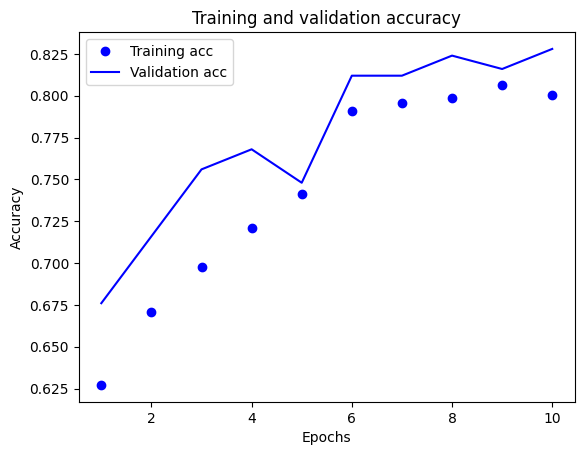

In [169]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [170]:
test = pd.read_csv("test.csv")
PassengerId = test["PassengerId"].values
test = preprocess_df(test)

/tmp/ipykernel_920/275173478.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_920/275173478.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [171]:
predictions = model.predict(test)

# Convert all predictions to 0 or 1
for i in range(len(predictions)):
    if predictions[i] < 0.5:
        predictions[i] = 0
    else:
        predictions[i] = 1

predictions = predictions.astype(int) # The submission format requires integers.
predictions = predictions.flatten() # This turns predictions into a 1D array that can be put into a dataframe.
        
data = {'PassengerId': PassengerId,
        'Survived': predictions}

prediction_df = pd.DataFrame(data)
prediction_df.tail()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [172]:
prediction_df.to_csv("predictions.csv", index=False)